# EMRI Waveforms in frequency domain

By: Lorenzo Speri and Michael L. Katz

We present the usage of the EMRI Waveforms in the Frequency domain and compare the spectrum to the time domain implementation. For details on the specifics of our waveforms like constructions and generally methodology, we refer you to our paper (). If you use the frequency domain waveform, please cite that paper. 

For full use of this tutorial, please install LISAAnalysis Tools with:
`pip install git+https://github.com/mikekatz04/LISAanalysistools.git@dev`

The tutorial is currently in an initial form. It will be cleaned up and commented soon...

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="SchwarzEccFlux")

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from few.utils.fdutils import *

import warnings
warnings.filterwarnings("ignore")


Initialize waveform generators.

In [2]:

# frequency domain
few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd", odd_len=True),
    return_list=True
)

# time domain
td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, odd_len=True),
    return_list=True
)


In [3]:
# define the injection parameters
M = 1e6 # central object mass
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 10.0 # secondary object mass
p0 = 12.0 # initial semi-latus rectum
e0 = 0.6 # eccentricity

x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = np.pi/3
Phi_theta0 = 0.0
Phi_r0 = np.pi/3

Tobs = 1.0 # observation time, if the inspiral is shorter, the it will be zero padded 
dt = 10.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,2,0)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following lines if you want to show a specific mode or modes
#     "mode_selection" : mode_selection,
#     "include_minus_m": True
    "eps": eps,
    
}

# get the initial p0 
p0 = get_p_at_t(
    traj_module,
    Tobs*0.99,
    [M, mu, 0.0, e0, 1.0],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)


emri_injection_params = [
    M,  
    mu,
    a, 
    p0, 
    e0, 
    x0,
    dist, 
    qS,
    phiS,
    qK, 
    phiK, 
    Phi_phi0, 
    Phi_theta0, 
    Phi_r0
]

## Comparison against the Time Domain Waveforms

In [4]:
# create TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)

# take the FFT of the plus polarization and shift it
fft_TD = np.fft.fftshift(np.fft.fft(data_channels_td[0])) * dt
freq = np.fft.fftshift(np.fft.fftfreq(len(data_channels_td[0]) , dt))

# define the positive frequencies
positive_frequency_mask = (freq>=0.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


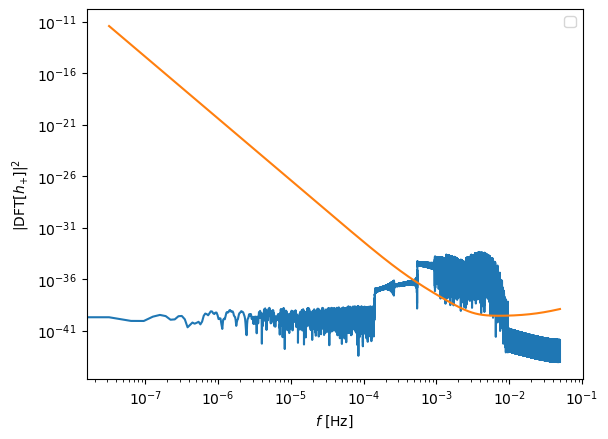

In [5]:
plt.figure()
plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2)
plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]))
plt.ylabel(r'$| {\rm DFT} [h_{+}]|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

In [6]:
# you can specify the frequencies or obtain them directly from the waveform
fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq
fd_kwargs['mask_positive']=True

# get FD waveform
hf = few_gen(*emri_injection_params,**fd_kwargs)
# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency

# mismatch
fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", f_arr=freq[positive_frequency_mask])
Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask], hf[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)

mismatch 0.0008526030054986089


In [7]:
# 220 mode
fd_kwargs2 = fd_kwargs.copy()
fd_kwargs2.pop("eps")
fd_kwargs2['mode_selection'] = [(2,2,0)]
hf_220 = few_gen(*emri_injection_params,**fd_kwargs2)
# create TD signal
td_kwargs2 = waveform_kwargs.copy()
td_kwargs2.pop("eps")
td_kwargs2['mode_selection'] = [(2,2,0)]
data_channels_td_220 = td_gen(*emri_injection_params, **td_kwargs2)

# take the FFT of the plus polarization and shift it
fft_TD_220 = np.fft.fftshift(np.fft.fft(data_channels_td_220[0])) * dt

# sig_fd_windowed = [el[positive_frequency_mask] for el in get_fd_windowed(hf_toconv, window)]

Mism = np.abs(1-inner_product(fft_TD_220[positive_frequency_mask], hf_220[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)

mismatch 4.694064207533266e-05


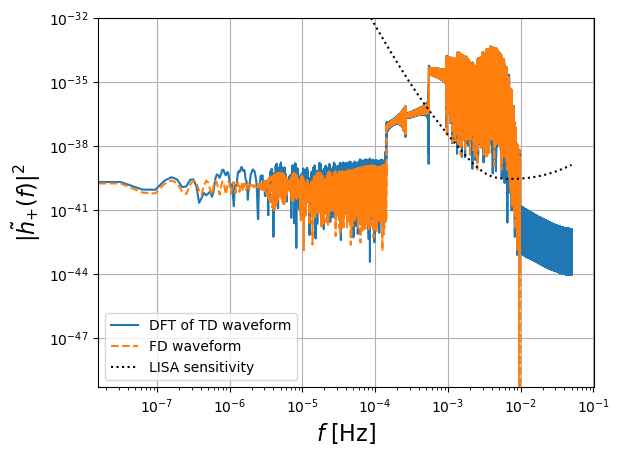

In [8]:
# FD plot
enlarge = 1.1
plt.figure()
plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2,label='DFT of TD waveform')
plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,'--',label='FD waveform')
plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]),'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_{+} (f)|^2$',fontsize=16)
plt.grid()
plt.xlabel(r'$f$ [Hz]',fontsize=16)
plt.legend(loc='lower left')
plt.ylim([0.5e-49, 1e-32])
plt.show()
# plt.savefig('figures/FD_TD_frequency.pdf', bbox_inches='tight')

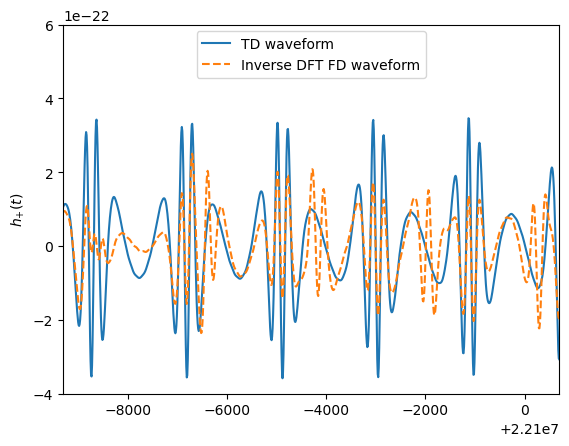

In [9]:
# TD plot
time_array = np.arange(0,len(data_channels_td[0]))*dt
ifft_fd = np.fft.ifft(np.append(hf[0],hf[0][::-1][:-1] )/dt)
ifft_fd_22 = np.fft.ifft(np.append(hf_220[0],np.flip(hf_220[0][1:] ))/dt)


enlarge = 1.1
plt.figure()

plt.plot(time_array, data_channels_td[0],label='TD waveform')
plt.plot(time_array, ifft_fd,'--' ,label='Inverse DFT FD waveform')
#     plt.plot(time_array, ifft_fd_22,'-.' ,label='Inverse DFT FD waveform (l,m,n)=(2,2,0)')
plt.ylabel(r'$h_{+}(t)$')
# plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 10e3
plt.xlim([t0,t0+space_t])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc='upper center')
plt.show()
# plt.savefig('figures/FD_TD_time.pdf', bbox_inches='tight')

## Windowing

In [10]:
# no windowing
window = None # np.asarray(hann(len(data_channels_td[0])))
fft_td_gen = GetFDWaveformFromTD(td_gen, positive_frequency_mask, dt, window=window)
fd_gen = GetFDWaveformFromFD(few_gen, positive_frequency_mask, dt, window=window)
fd_kwargs_nomask = fd_kwargs.copy()
del fd_kwargs_nomask['mask_positive']
np.all(fd_gen(*emri_injection_params,**fd_kwargs_nomask)[0]==hf[0])

# add windowing
window = np.asarray(hann(len(data_channels_td[0])))#np.asarray(data_channels_td[0]==0.0,dtype=float)#
fft_td_gen = GetFDWaveformFromTD(td_gen, positive_frequency_mask, dt, window=window)
fd_gen = GetFDWaveformFromFD(few_gen, positive_frequency_mask, dt, window=window)

hf = fd_gen(*emri_injection_params,**fd_kwargs_nomask)
fft_TD = fft_td_gen(*emri_injection_params,**fd_kwargs_nomask)

fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", f_arr=freq[positive_frequency_mask])
Mism = np.abs(1-inner_product(fft_TD[0], hf[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)

mismatch 3.909195435469748e-06


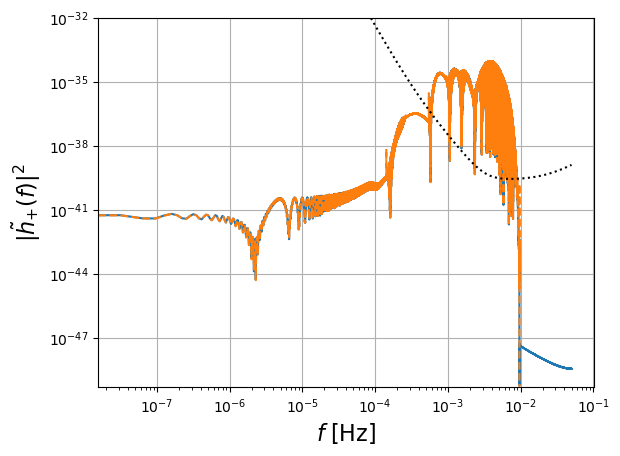

In [11]:
# FD plot
enlarge = 1.1
plt.figure()
plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[0])**2,label='DFT of TD waveform')
plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,'--',label='FD waveform')
plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]),'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_{+}(f)|^2$',fontsize=16)
plt.xlabel(r'$f$ [Hz]',fontsize=16)
# plt.legend(loc='upper left')
plt.grid()
plt.ylim([0.5e-49, 1e-32])
plt.show()
# plt.savefig('figures/FD_TD_frequency_windowed.pdf', bbox_inches='tight')

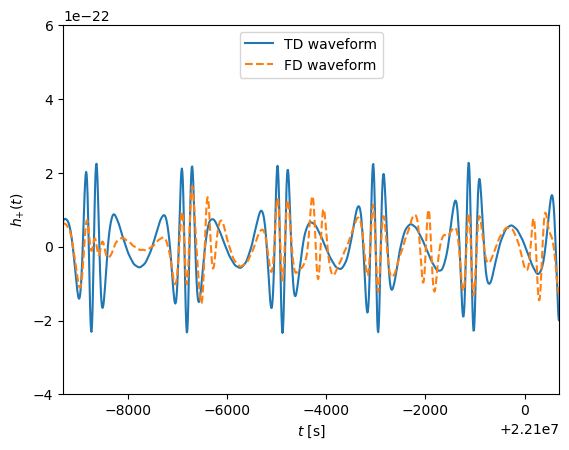

In [12]:
# TD plot
time_array = np.arange(0,len(data_channels_td[0]))*dt
ifft_fd = np.fft.ifft(np.append(hf[0],hf[0][::-1][:-1] )/dt)


enlarge = 1.1
plt.figure()

plt.plot(time_array, data_channels_td[0]*window,label='TD waveform')
plt.plot(time_array, ifft_fd,'--' ,label='FD waveform')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 10e3
plt.xlim([t0,t0+space_t])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc='upper center')
plt.show()
# plt.savefig('figures/FD_TD_time_windowed.pdf', bbox_inches='tight')

## Mass invariance
If we fix the mass ratio of an EMRI system the frequency domain waveform is invariant under a total mass change as long as we consider dimensionless frequencies. We show this here as a check of our frequency domain implementation.

In [13]:
list_h = []
list_f = []
T = 4.0
dt = 10.0
# array of total masses
Mvec = 10**np.linspace(5.0,6.5,num=3)

for M in Mvec:

    # fix mass ratio
    mu = 5e-5*M

    # rescale time
    Tnew = T*(M/1e6)
    
    # generate wave
    list_h.append(
        few_gen(M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,
                T=10.0,dt=dt,mode_selection=[(2,2,0)],mask_positive=True)
    )

    # dimensionless frequency
    list_f.append(few_gen.waveform_generator.create_waveform.frequency * M * MTSUN_SI )
    

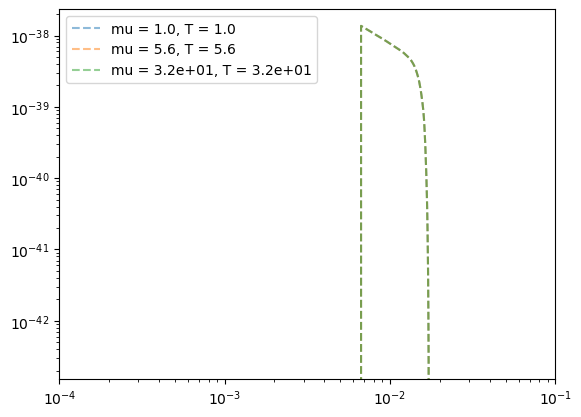

In [14]:
plt.figure()
for ii in range(len(Mvec)):
    Tnew = 10.0 * Mvec[ii] / 1e6
    tmp_mu = 1e-5 * Mvec[ii]
    
    ff = list_f[ii]
    ff = ff[ff>=0.0]
    h2 = np.abs(list_h[ii][0] / (tmp_mu * Tnew) )**2 
    plt.loglog(ff, h2,'--', label = f'mu = {tmp_mu:.2}, T = {Tnew:.2}',alpha=0.5)

plt.xlim([1e-4,1e-1])
plt.legend()
plt.show()

## Downsampled FD Waveforms
One of the main advantages of the frequency domain formulation is that we can downsample the frequencies to reduce the computational cost of the waveform. This is illustrated in the following cells where we perform different levels of downsampling.

In [16]:
M,mu,p0,e0 = 3670041.7362535275, 292.0583167470244, 13.709101864726545, 0.5794130830706371 # 1e6, 10.0, 13.709101864726545, 0.5794130830706371 # 

x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = np.pi/3
Phi_theta0 = 0.0
Phi_r0 = np.pi/3

Tobs = 4.0 # observation time, if the inspiral is shorter, the it will be zero padded 
dt = 10.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,2,0)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following ling if you want to show a mode
#     "mode_selection" : mode_selection,
#     "include_minus_m": True
    "eps": eps,
    
}

# get the initial p0 
p0 = get_p_at_t(
    traj_module,
    Tobs*0.99,
    [M, mu, 0.0, e0, 1.0],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)


emri_injection_params = [
    M,  
    mu,
    a, 
    p0, 
    e0, 
    x0,
    dist, 
    qS,
    phiS,
    qK, 
    phiK, 
    Phi_phi0, 
    Phi_theta0, 
    Phi_r0
]

max frequency 0.002815722498330661
max frequency 0.002815722498330661


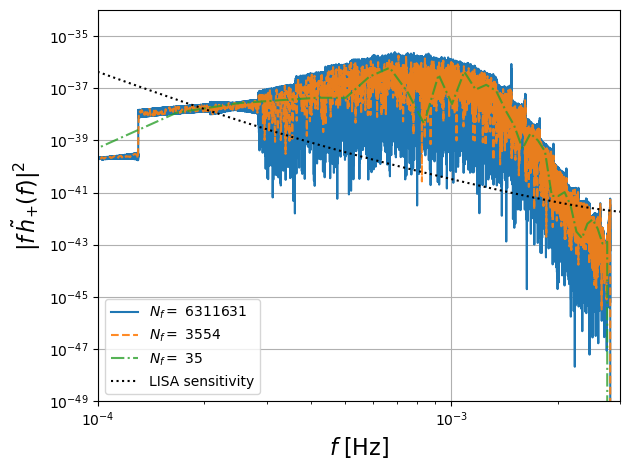

In [17]:
# FD plot
enlarge = 1.1
plt.figure()

alpha=[1.0,0.9, 0.8, 0.2]
linest = ['-','--','-.',':']

for upp,aa,ls in zip([1, 100,10000],alpha,linest):

    # you can specify the frequencies or obtain them directly from the waveform
    fd_kwargs = waveform_kwargs.copy()
    fd_kwargs['mask_positive']=True
    # get FD waveform
    hf = few_gen(*emri_injection_params,**fd_kwargs)
    freq_fd = few_gen.waveform_generator.create_waveform.frequency
    positive_frequency_mask = (freq_fd>=0.0)
    mask_non_zero = (hf[0]!=complex(0.0))
    end_f = few_gen.waveform_generator.create_waveform.frequency[positive_frequency_mask][mask_non_zero].max()

    if upp!=1:
        num = int( len(freq_fd[positive_frequency_mask][mask_non_zero]) / upp )
        p_freq = np.linspace(0.0, end_f*1.01, num=num ) 
        print("max frequency",end_f)
        newfreq = np.hstack((-p_freq[::-1][:-1],
                            p_freq
                            ) )

        # you can specify the frequencies or obtain them directly from the waveform
        fd_kwargs = waveform_kwargs.copy()
        fd_kwargs['f_arr'] = newfreq
        fd_kwargs['mask_positive']=True

        # get FD waveform
        hf = few_gen(*emri_injection_params,**fd_kwargs)
        # to get the frequencies:
        freq_fd = few_gen.waveform_generator.create_waveform.frequency
        positive_frequency_mask = (freq_fd>=0.0)

    Nf = len(freq_fd[positive_frequency_mask])
    plt.loglog(freq_fd[positive_frequency_mask],freq_fd[positive_frequency_mask]**2 * np.abs(hf[0])**2,ls,label=f'$N_f = $ {Nf}',alpha=aa)


ff = 10**np.linspace(-5,-1,num=100)
plt.loglog(ff, ff*get_sensitivity(ff),'k:',label='LISA sensitivity')

plt.ylabel(r'$|f\, \tilde{h}_{+}(f)|^2$',fontsize=16)
plt.xlabel(r'$f$ [Hz]',fontsize=16)
plt.legend(loc='lower left')
plt.xlim(1e-4,3e-3)
plt.grid()
plt.ylim([1e-49, 1e-34])
plt.tight_layout()
plt.show()

# plt.savefig('figures/spectrum_downsampled.pdf')